# GAN_Using_Tensorflow

In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import math

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, Conv2D, Flatten, Activation, BatchNormalization, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam



Hyperparameters
--

In [2]:
data = "../data/training/"
batch_size = 32
image_size = 64
no_of_channels = 3
latent = 100
lr = 0.0002
no_of_img = 2
beta_1 = 0.5
beta_2 = 0.999
num_epochs = 500



Dataset loading
--

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 1081 files belonging to 1 classes.


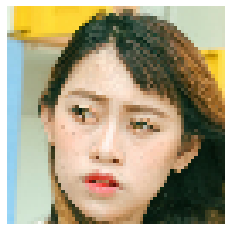

In [4]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

Generator model
--

In [5]:
# Generator Code

def Generator():
    # layer_1 input is Z
    inp = Input(shape = (latent,))
    x = Dense(8 * 8 * 128)(inp)
    x = Reshape((8, 8, 128))(x)
    x = Conv2DTranspose(512, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(256, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    out = Conv2D(3, kernel_size=4, padding="same", activation = "tanh")(x)
    generator = Model(inputs = inp, outputs = out, name = " generator")    
    return generator
    
model= Generator()
model.summary()

Model: " generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 512)       1049088   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       2097408   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 256)       0

Discriminator model
--

In [6]:
# Discriminator Code
def Discriminator():
    inp = Input(shape = (image_size,image_size,no_of_channels))
    x = Conv2D(64, kernel_size = 4 , strides =2, padding = 'same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Conv2D(128, kernel_size = 4, strides =2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Conv2D(256, kernel_size = 4, strides =2, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Conv2D(512, kernel_size = 4, strides =2, padding = 'same')(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation = "sigmoid")(x)
    disc = Model(inputs = inp, outputs = out, name = "discriminator")
    return disc

model = Discriminator()
model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)     

Loss and Optimizer
--

In [7]:
loss = tf.keras.losses.BinaryCrossentropy()
optimizerD = Adam(learning_rate=lr, beta_1 = beta_1, beta_2 = beta_2)
optimizerG = Adam(learning_rate=lr, beta_1 = beta_1, beta_2 = beta_2)

loss_metric_D = tf.keras.metrics.Mean(name="d_loss")
loss_metric_G = tf.keras.metrics.Mean(name="g_loss")


generator = Generator()
discriminator = Discriminator()


Training Step
--

In [8]:
imgs_array = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataset, 0):
        batch_size = tf.shape(data)[0]
        latent_vectors = tf.random.normal(shape=(batch_size, latent))
        fake_images = generator(latent_vectors)
        all_images = tf.concat([fake_images, data], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(all_images)
            loss_D = loss(labels, predictions)
        grads = tape.gradient(loss_D, discriminator.trainable_weights)
        optimizerD.apply_gradients(
            zip(grads, discriminator.trainable_weights)
        )

        latent_vectors = tf.random.normal(shape=(batch_size, latent))
        fake_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = discriminator(generator(latent_vectors))
            loss_G = loss(fake_labels, predictions)
        grads = tape.gradient(loss_G, generator.trainable_weights)
        optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

        # Update metrics
        loss_metric_D.update_state(loss_D)
        loss_metric_G.update_state(loss_G)
        
        if i % 50 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}] [{i} /{len(dataset)}] , \nLoss_D: {loss_metric_D.result():.4f}, Loss_G: {loss_metric_G.result():.4f}')
        
         # Save Losses for plotting later
        D_losses.append(loss_metric_D.result())
        G_losses.append(loss_metric_G.result())

      
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataset)-1)):
            latent_vectors = tf.random.normal(shape=(no_of_img, latent))
            generated_images = generator(latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(no_of_img):
                img_list = tf.keras.preprocessing.image.array_to_img(generated_images[i])
                imgs_array.append(img_list)
                img_list.save("./Fake/fake_image_%03d_%d.png" % (epoch+1, i))
            
        iters += 1

Starting Training Loop...
Epoch [1/500] [0 /34] , 
Loss_D: 0.7026, Loss_G: 0.6924
Epoch [2/500] [0 /34] , 
Loss_D: 0.5509, Loss_G: 0.9015
Epoch [3/500] [0 /34] , 
Loss_D: 0.5503, Loss_G: 1.1753
Epoch [4/500] [0 /34] , 
Loss_D: 0.5700, Loss_G: 1.1821
Epoch [5/500] [0 /34] , 
Loss_D: 0.5883, Loss_G: 1.1567
Epoch [6/500] [0 /34] , 
Loss_D: 0.6057, Loss_G: 1.1100
Epoch [7/500] [0 /34] , 
Loss_D: 0.6180, Loss_G: 1.0770
Epoch [8/500] [0 /34] , 
Loss_D: 0.6247, Loss_G: 1.0539
Epoch [9/500] [0 /34] , 
Loss_D: 0.6312, Loss_G: 1.0245
Epoch [10/500] [0 /34] , 
Loss_D: 0.6368, Loss_G: 1.0108
Epoch [11/500] [0 /34] , 
Loss_D: 0.6397, Loss_G: 0.9976
Epoch [12/500] [0 /34] , 
Loss_D: 0.6436, Loss_G: 0.9822
Epoch [13/500] [0 /34] , 
Loss_D: 0.6461, Loss_G: 0.9732
Epoch [14/500] [0 /34] , 
Loss_D: 0.6485, Loss_G: 0.9680
Epoch [15/500] [0 /34] , 
Loss_D: 0.6495, Loss_G: 0.9647
Epoch [16/500] [0 /34] , 
Loss_D: 0.6505, Loss_G: 0.9652
Epoch [17/500] [0 /34] , 
Loss_D: 0.6524, Loss_G: 0.9620
Epoch [18/500]

Epoch [144/500] [0 /34] , 
Loss_D: 0.5144, Loss_G: 1.5512
Epoch [145/500] [0 /34] , 
Loss_D: 0.5115, Loss_G: 1.5699
Epoch [146/500] [0 /34] , 
Loss_D: 0.5084, Loss_G: 1.5896
Epoch [147/500] [0 /34] , 
Loss_D: 0.5059, Loss_G: 1.6096
Epoch [148/500] [0 /34] , 
Loss_D: 0.5033, Loss_G: 1.6280
Epoch [149/500] [0 /34] , 
Loss_D: 0.5004, Loss_G: 1.6470
Epoch [150/500] [0 /34] , 
Loss_D: 0.4982, Loss_G: 1.6656
Epoch [151/500] [0 /34] , 
Loss_D: 0.4956, Loss_G: 1.6837
Epoch [152/500] [0 /34] , 
Loss_D: 0.4929, Loss_G: 1.7029
Epoch [153/500] [0 /34] , 
Loss_D: 0.4904, Loss_G: 1.7220
Epoch [154/500] [0 /34] , 
Loss_D: 0.4876, Loss_G: 1.7416
Epoch [155/500] [0 /34] , 
Loss_D: 0.4851, Loss_G: 1.7622
Epoch [156/500] [0 /34] , 
Loss_D: 0.4829, Loss_G: 1.7818
Epoch [157/500] [0 /34] , 
Loss_D: 0.4803, Loss_G: 1.8004
Epoch [158/500] [0 /34] , 
Loss_D: 0.4776, Loss_G: 1.8211
Epoch [159/500] [0 /34] , 
Loss_D: 0.4748, Loss_G: 1.8419
Epoch [160/500] [0 /34] , 
Loss_D: 0.4722, Loss_G: 1.8633
Epoch [161/500

Epoch [286/500] [0 /34] , 
Loss_D: 0.2801, Loss_G: 4.9929
Epoch [287/500] [0 /34] , 
Loss_D: 0.2792, Loss_G: 5.0246
Epoch [288/500] [0 /34] , 
Loss_D: 0.2781, Loss_G: 5.0525
Epoch [289/500] [0 /34] , 
Loss_D: 0.2775, Loss_G: 5.0800
Epoch [290/500] [0 /34] , 
Loss_D: 0.2767, Loss_G: 5.1053
Epoch [291/500] [0 /34] , 
Loss_D: 0.2757, Loss_G: 5.1325
Epoch [292/500] [0 /34] , 
Loss_D: 0.2747, Loss_G: 5.1615
Epoch [293/500] [0 /34] , 
Loss_D: 0.2737, Loss_G: 5.1917
Epoch [294/500] [0 /34] , 
Loss_D: 0.2728, Loss_G: 5.2227
Epoch [295/500] [0 /34] , 
Loss_D: 0.2719, Loss_G: 5.2522
Epoch [296/500] [0 /34] , 
Loss_D: 0.2710, Loss_G: 5.2815
Epoch [297/500] [0 /34] , 
Loss_D: 0.2702, Loss_G: 5.3107
Epoch [298/500] [0 /34] , 
Loss_D: 0.2691, Loss_G: 5.3416
Epoch [299/500] [0 /34] , 
Loss_D: 0.2681, Loss_G: 5.3739
Epoch [300/500] [0 /34] , 
Loss_D: 0.2674, Loss_G: 5.4009
Epoch [301/500] [0 /34] , 
Loss_D: 0.2666, Loss_G: 5.4290
Epoch [302/500] [0 /34] , 
Loss_D: 0.2659, Loss_G: 5.4547
Epoch [303/500

Epoch [428/500] [0 /34] , 
Loss_D: 0.1782, Loss_G: 10.1785
Epoch [429/500] [0 /34] , 
Loss_D: 0.1776, Loss_G: 10.2304
Epoch [430/500] [0 /34] , 
Loss_D: 0.1771, Loss_G: 10.2754
Epoch [431/500] [0 /34] , 
Loss_D: 0.1766, Loss_G: 10.3227
Epoch [432/500] [0 /34] , 
Loss_D: 0.1760, Loss_G: 10.3722
Epoch [433/500] [0 /34] , 
Loss_D: 0.1752, Loss_G: 10.4271
Epoch [434/500] [0 /34] , 
Loss_D: 0.1747, Loss_G: 10.4761
Epoch [435/500] [0 /34] , 
Loss_D: 0.1742, Loss_G: 10.5239
Epoch [436/500] [0 /34] , 
Loss_D: 0.1736, Loss_G: 10.5741
Epoch [437/500] [0 /34] , 
Loss_D: 0.1730, Loss_G: 10.6228
Epoch [438/500] [0 /34] , 
Loss_D: 0.1724, Loss_G: 10.6772
Epoch [439/500] [0 /34] , 
Loss_D: 0.1717, Loss_G: 10.7319
Epoch [440/500] [0 /34] , 
Loss_D: 0.1710, Loss_G: 10.7874
Epoch [441/500] [0 /34] , 
Loss_D: 0.1705, Loss_G: 10.8388
Epoch [442/500] [0 /34] , 
Loss_D: 0.1700, Loss_G: 10.8862
Epoch [443/500] [0 /34] , 
Loss_D: 0.1693, Loss_G: 10.9393
Epoch [444/500] [0 /34] , 
Loss_D: 0.1688, Loss_G: 10.98

Result
---

Loss plot
--

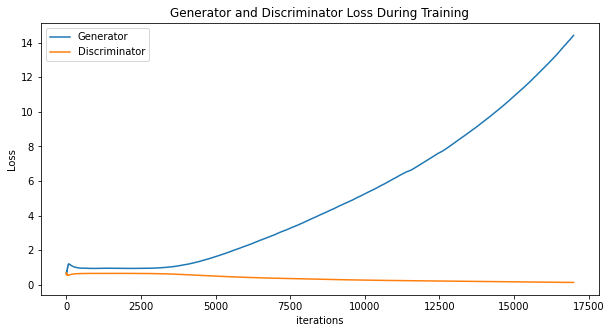

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Fake Images
-

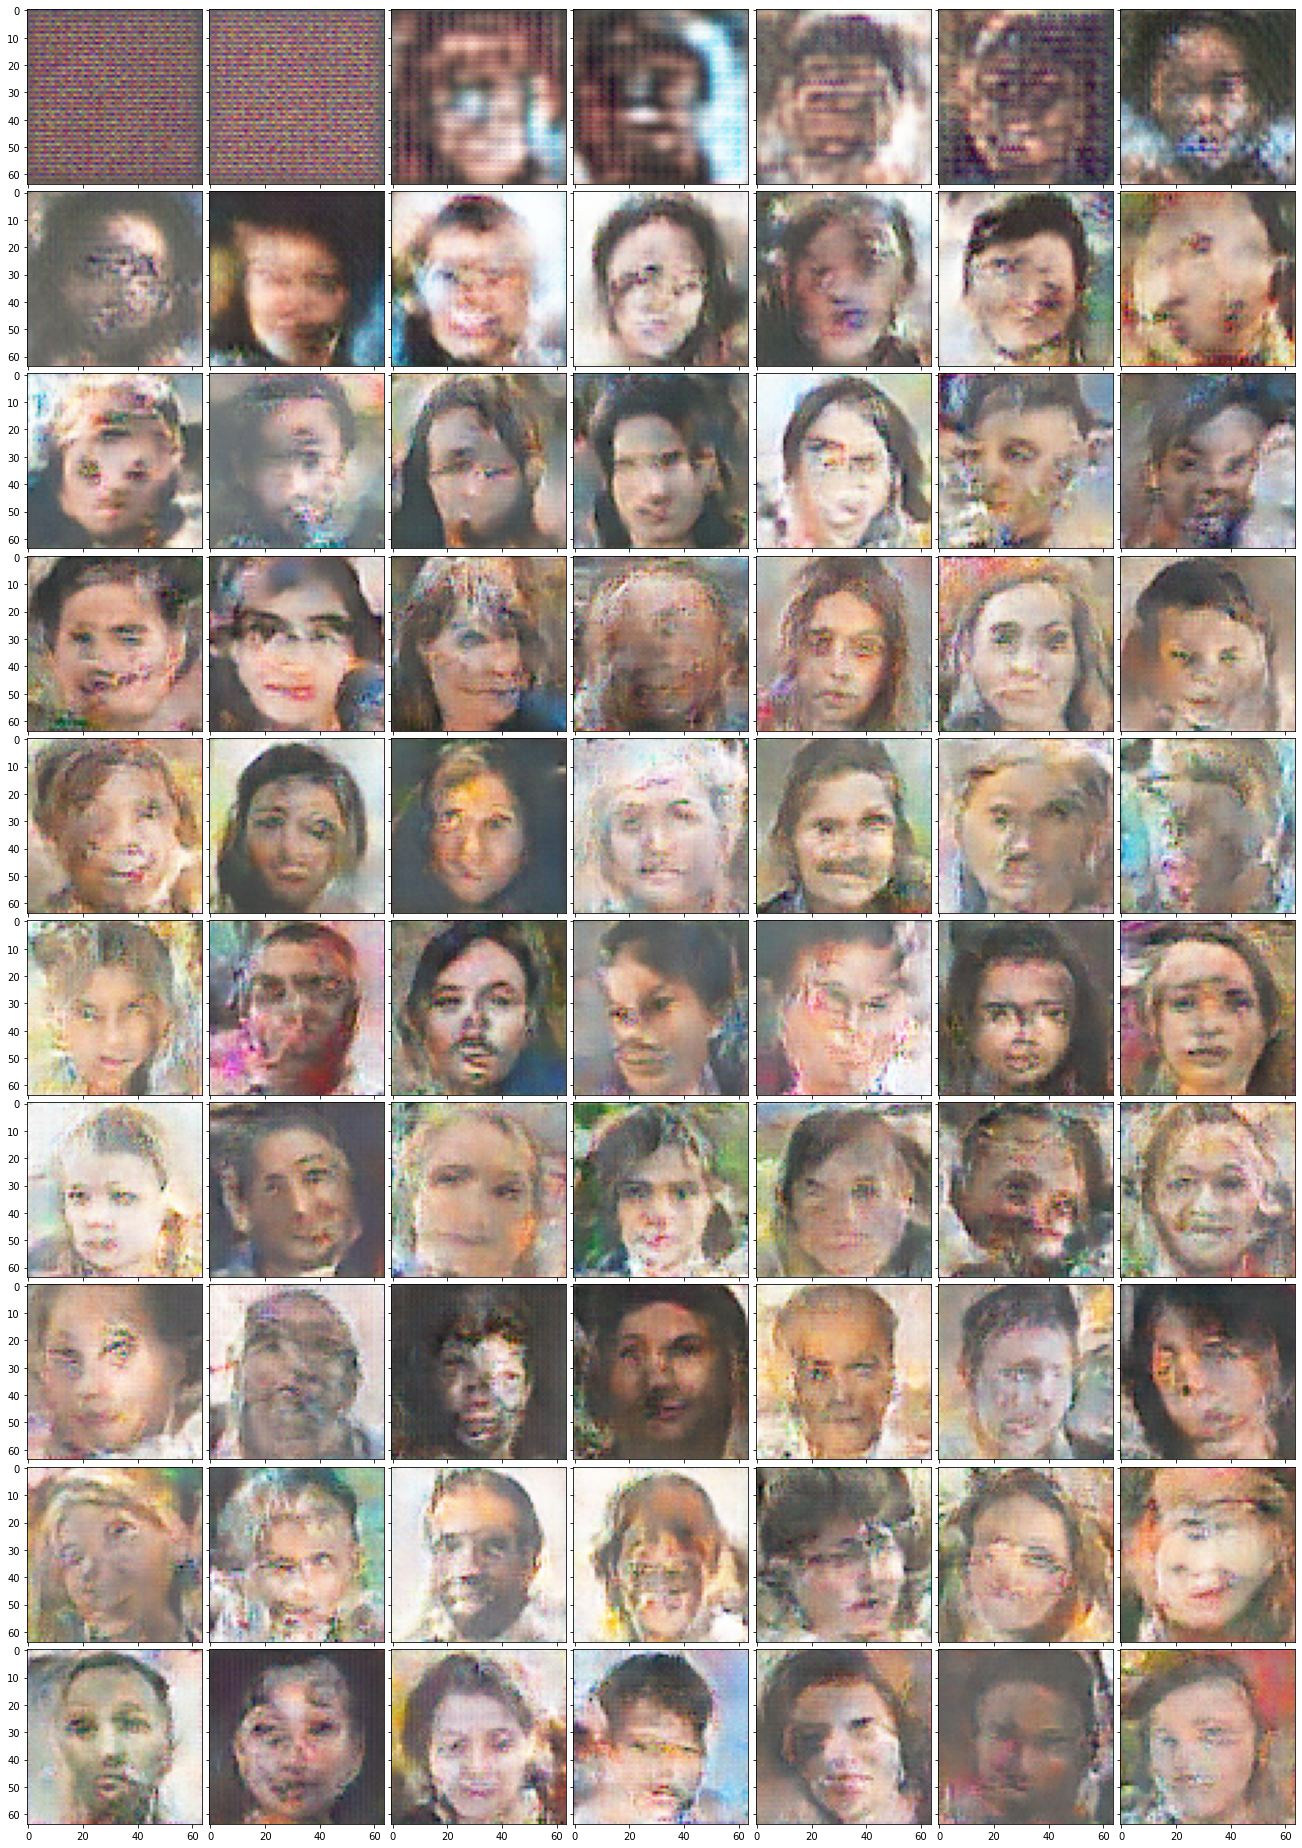

In [12]:

columns = 7
rows = math.ceil(len(imgs_array)/columns)


fig = plt.figure(figsize=(50, 50))
grid = ImageGrid(fig, 122,  # similar to subplot(111)
                 nrows_ncols=(rows, columns),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, imgs_array):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()